In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [44]:
ca_df = pd.read_csv('ca_df.csv')

In [45]:
conns = pd.read_csv('Connections.csv')
segs = pd.read_csv('L5Segments.csv')
segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Type','Sec ID'])['Degrees'].max().reset_index()
segs['segmentID'] = segs.index
segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()

conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))
conns.loc[conns.Type=='apic','Sec ID'] = conns.loc[conns.Type=='apic','Name'].apply(lambda x: int(x.split('apic[')[1].split(']')[0]))
conns.loc[conns.Type=='soma','Sec ID'] = conns.loc[conns.Type=='soma','Name'].apply(lambda x: int(x.split('soma[')[1].split(']')[0]))
conns.loc[conns.Type=='axon','Sec ID'] = conns.loc[conns.Type=='axon','Name'].apply(lambda x: int(x.split('axon[')[1].split(']')[0]))

conns['X'] = conns['Name'].apply(lambda x: float(x.split('(')[1].split(')')[0]))

conns.rename(columns={'Distance':'conns_Distance'},inplace=True)

conns['Sec ID'] = conns['Sec ID'].astype(int)
conns['X'] = conns['X'].astype(float)

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)

segs['Elec_distanceQ'] = 'None'

segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False)
segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False)

In [46]:
segs_ca_df = segs.set_index('segmentID').join(ca_df.set_index('segmentID')).reset_index()

In [47]:
segs_ca_df[(segs_ca_df.Type=='apic') & (~pd.isnull(segs_ca_df.ca_lower_bound))].drop_duplicates(subset='ca_lower_bound')


,segmentID,Type,Sec ID,BMTK ID,X,Distance,Coord X,Coord Y,Coord Z,Elec_distance,Degrees,Elec_distanceQ,Unnamed: 0,na_lower_bound,ca_lower_bound
1040,1040,apic,1,86,0.346154,80.254802,-16.295059,67.300051,3.654825,0.922488,2,9,0.0,NaN,0.0
1050,1049,apic,2,87,0.100000,125.707142,-20.165805,110.894753,8.035568,0.834321,3,9,1.0,NaN,216229.0
1051,1049,apic,2,87,0.100000,125.707142,-20.165805,110.894753,8.035568,0.834321,3,9,2.0,NaN,1210262.0
1053,1050,apic,2,87,0.300000,131.481450,-20.161000,116.505119,6.836384,0.822341,3,9,1.0,NaN,1210260.0
1055,1051,apic,2,87,0.500000,137.255759,-19.478333,121.977183,5.219003,0.810390,3,9,1.0,NaN,455555.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329816,2491,apic,105,190,0.921053,167.347659,-94.632744,84.965838,-48.580974,0.051683,3,5,19.0,NaN,1400447.0
329835,2492,apic,105,190,0.973684,172.278122,-98.815349,86.356414,-49.924340,0.048964,3,5,17.0,NaN,1231286.0
329848,2501,apic,107,192,0.500000,121.198641,-53.364582,64.412122,-44.010966,0.095414,4,7,0.0,NaN,380154.0
329865,2510,apic,108,193,0.785714,126.779844,-57.005121,51.834454,-45.517306,0.085551,4,6,0.0,NaN,106933.0


In [48]:
v = h5py.File('./output/v_report.h5','r')
hva = h5py.File('./output/Ca_HVA.ica_report.h5','r')
lva = h5py.File('./output/Ca_LVAst.ica_report.h5','r')
ih = h5py.File('./output/Ih.ihcn_report.h5','r')

nmda = h5py.File('./output/inmda_report.h5','r')

na = h5py.File('./output/NaTa_t.gNaTa_t_report.h5','r')
spks = h5py.File('./output/spikes.h5','r')

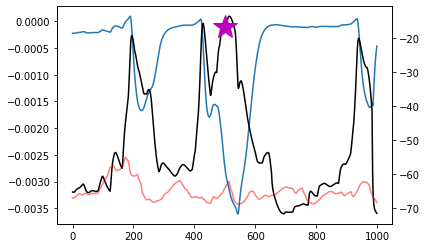

In [52]:
ca_spk_idx = int(np.random.choice(segs_ca_df[(segs_ca_df.Type=='apic') 
                         & (~pd.isnull(segs_ca_df.ca_lower_bound))].drop_duplicates(subset='ca_lower_bound').index))

ca_spk_time = int(segs_ca_df.loc[ca_spk_idx,'ca_lower_bound'])
ca_spk_seg = int(segs_ca_df.loc[ca_spk_idx,'segmentID'])


plt.plot(hva['report']['biophysical']['data'][ca_spk_time-500:ca_spk_time+500,ca_spk_seg]+
         lva['report']['biophysical']['data'][ca_spk_time-500:ca_spk_time+500,ca_spk_seg]+
         ih['report']['biophysical']['data'][ca_spk_time-500:ca_spk_time+500,ca_spk_seg])

plt.twinx()

plt.plot(v['report']['biophysical']['data'][ca_spk_time-500:ca_spk_time+500,ca_spk_seg],color='k')
plt.plot(v['report']['biophysical']['data'][ca_spk_time-500:ca_spk_time+500,0],color='r',alpha=0.5)

plt.plot(500,v['report']['biophysical']['data'][ca_spk_time,ca_spk_seg],'m*',markersize=25)

In [60]:
spktimes = np.sort(np.random.choice(segs_ca_df[(segs_ca_df.Type=='apic') & 
           (~pd.isnull(segs_ca_df.ca_lower_bound))].drop_duplicates(subset='ca_lower_bound')['ca_lower_bound'],10000)/10)



In [61]:
nmda_df = pd.read_csv('nmda_df.csv')
nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)
segs_nmda_df = segs.set_index('segmentID').join(nmda_df.set_index('segmentID')).reset_index()

In [62]:
nmda_dend = np.zeros((10,27,))
nmda_apic = np.zeros((10,27,))

edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                               (segs_nmda_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                               (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))

actual_spktimes = []
c = 0
for i in np.sort(spktimes):
    # excludes bursts
    if i-c > 10:
        for e in np.arange(0,10):
            nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                 (segs_nmda_df.Type=='dend')&
                                 (segs_nmda_df.Elec_distance>edges_dend[e])&
                                 (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)

            x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
            nmda_dend[e] += x2
            
            nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                 (segs_nmda_df.Type=='apic')&
                                 (segs_nmda_df.Elec_distance>edges_apic[e])&
                                 (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)

            x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
            nmda_apic[e] += x2
        
        actual_spktimes.append(i)
    c = i

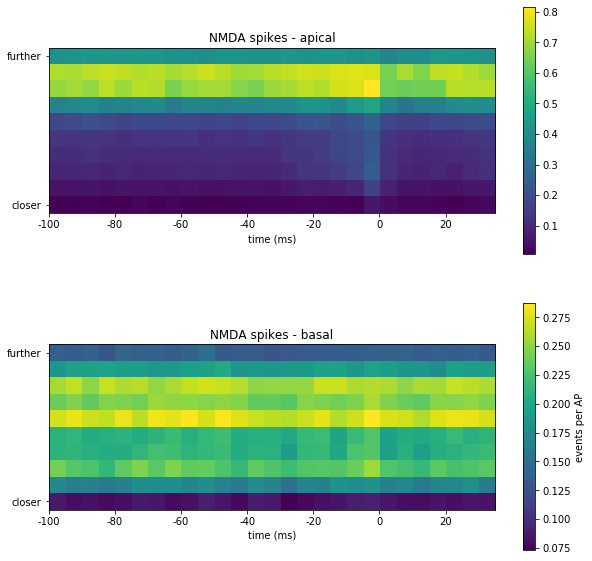

In [64]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow(nmda_apic/len(spktimes))
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar()
plt.xlabel('time (ms)')

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow(nmda_dend/len(spktimes))
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='events per AP')

plt.xlabel('time (ms)')
plt.show()